In [1]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw
import pandas as pd
import numpy as np
import json
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les SMILES depuis le fichier
with open("ligands.txt", "r") as f:
    smiles_list = [line.strip() for line in f if line.strip()]

# Charger le dictionnaire des scores de docking
with open("ligand_dict.txt", "r") as f:
    score_dict = json.load(f)

# Convertir les SMILES en Mol et associer les scores
mols = []
valid_smiles = []
scores = []

for smi in smiles_list:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        mols.append(mol)
        valid_smiles.append(smi)
        scores.append(score_dict.get(smi, None))  # None si absent


/home/maillasson-m/miniforge3/envs/smiles_cluster/lib/python3.10/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
# Générer les MACCS fingerprints
fps = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]
fps_array = np.array([fp.ToList() for fp in fps])

# Réduction de dimension par PCA
pca = PCA(n_components=2)
fps_pca = pca.fit_transform(fps_array)

# Clustering hiérarchique
clusterer = AgglomerativeClustering(n_clusters=4)
labels = clusterer.fit_predict(fps_array)

# Créer un dataframe
df = pd.DataFrame(fps_pca, columns=["PC1", "PC2"])
df["SMILES"] = valid_smiles
df["Cluster"] = labels.astype(str)
df["Score"] = scores


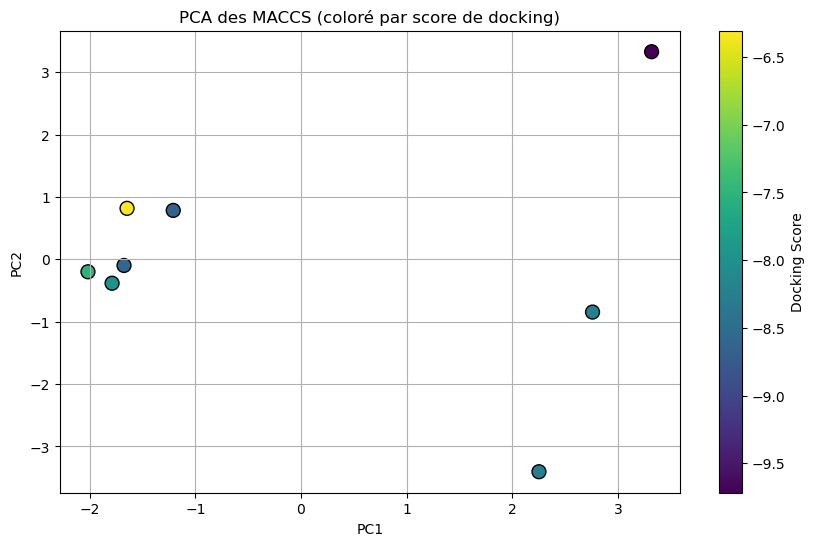

In [3]:
# Affichage PCA avec scores en couleurs
plt.figure(figsize=(10, 6))
sc = plt.scatter(df["PC1"], df["PC2"], c=df["Score"], cmap="viridis", s=100, edgecolor='k')
plt.title("PCA des MACCS (coloré par score de docking)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(sc, label="Docking Score")
plt.grid(True)
plt.show()


In [4]:
# Sauvegarder les clusters avec scores
df.to_csv("clusters_maccs_scores.csv", index=False)
print("Fichier 'clusters_maccs_scores.csv' exporté.")


Fichier 'clusters_maccs_scores.csv' exporté.


Cluster 0 - Meilleurs scores :


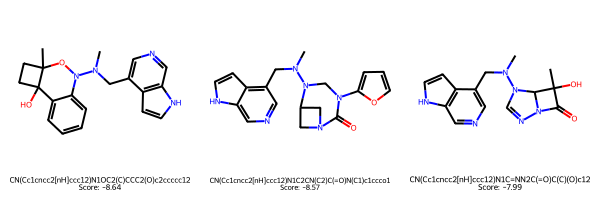

Cluster 1 - Meilleurs scores :


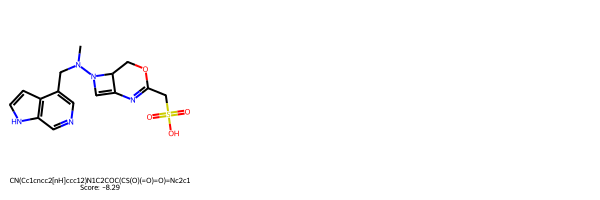

Cluster 2 - Meilleurs scores :


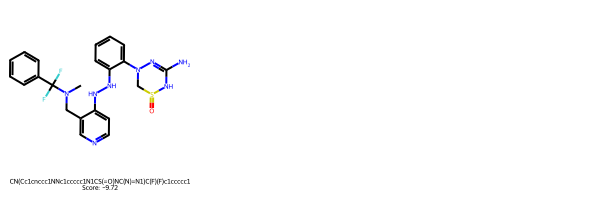

Cluster 3 - Meilleurs scores :


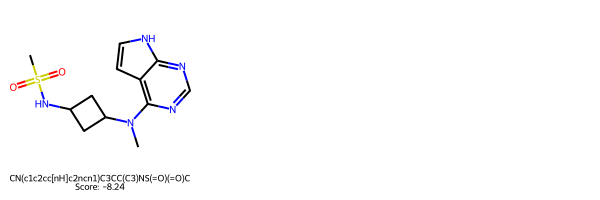

In [4]:
from IPython.display import display

n_per_cluster = 3
for clust in sorted(df["Cluster"].unique()):
    sub_df = df[df["Cluster"] == clust].nsmallest(n_per_cluster, "Score")
    mols_to_draw = [Chem.MolFromSmiles(smi) for smi in sub_df["SMILES"]]
    legends = [f"{smi}\nScore: {score:.2f}" for smi, score in zip(sub_df["SMILES"], sub_df["Score"])]
    print(f"Cluster {clust} - Meilleurs scores :")
    display(Draw.MolsToGridImage(mols_to_draw, molsPerRow=3, subImgSize=(200, 200), legends=legends))
